<a href="https://colab.research.google.com/github/smlra-kjsce/Generative-AI/blob/main/ControlNet_on_Poses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Installing Dependencies

In [1]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.5 MB/s eta 0:00:00


In [2]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image
import cv2
from PIL import Image
import numpy as np
from diffusers import ControlNetModel
import torch



##ControlNet on Poses

We will load some yoga poses and convert them to super heros..

In [3]:
def image_grid(imgs, rows, cols):
  #Generates a grid of the generated images
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


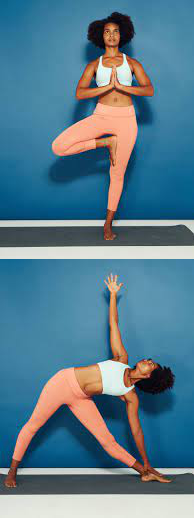

In [4]:
urls = "yoga1.jpeg", "yoga2.jpeg"
imgs = [
    load_image("https://hf.co/datasets/YiYiXu/controlnet-testing/resolve/main/" + url) 
    for url in urls
]

image_grid(imgs, 2, 1)

We will load another pre trained model to detect the poses from the images

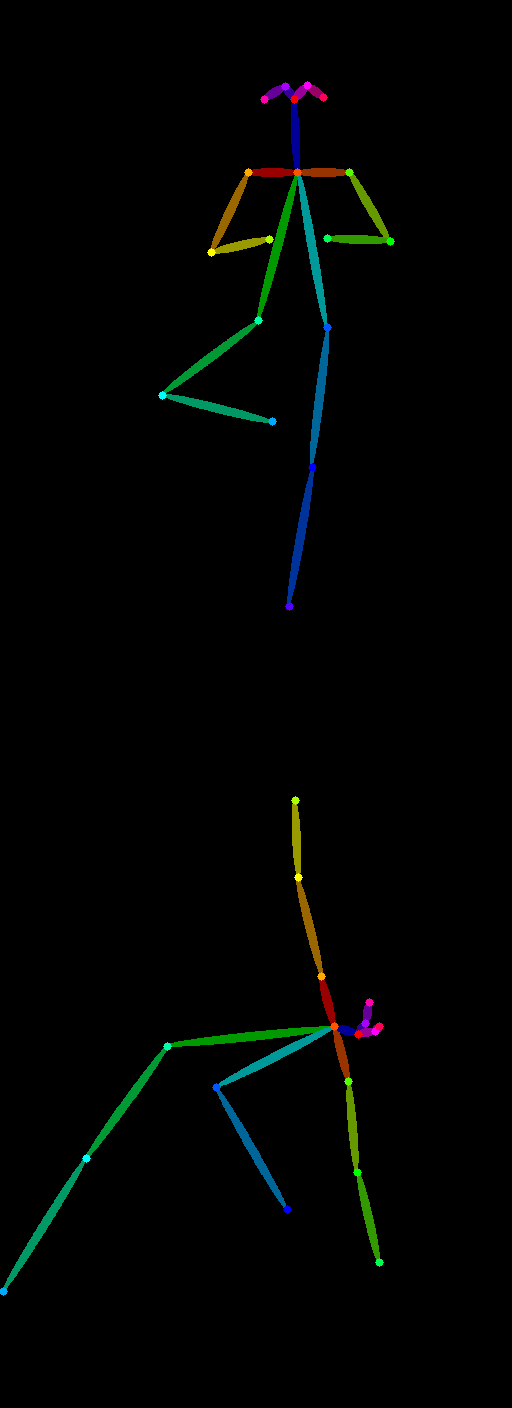

In [5]:
from controlnet_aux import OpenposeDetector
#Detect poses from the images and convert them to images

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [model(img) for img in imgs]
image_grid(poses, 2, 1)

We load the ControlNet model for the poses

In [ ]:
#We import pretrained controlnet openpose pipeline 
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)
#We generate some superhero images

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)

from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


We enter the prompt for to convert the image from poses to superheros..

Prompt: super-hero character, best quality, extremely detailed 

  0%|          | 0/20 [00:00<?, ?it/s]

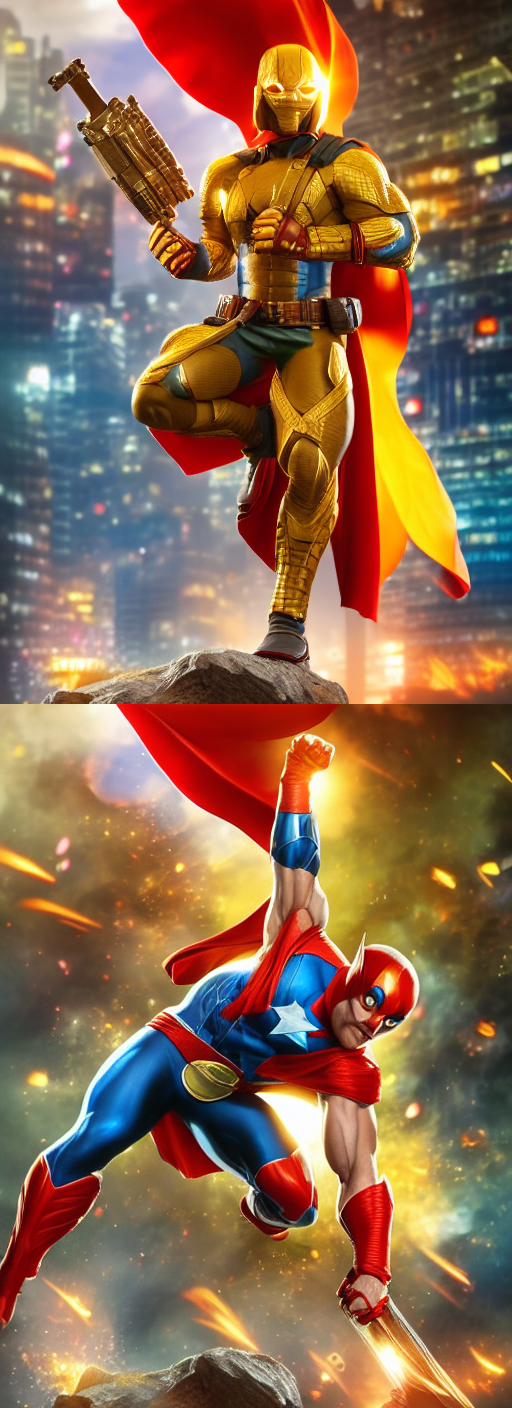

In [ ]:
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(2)]
prompt = "super-hero character, best quality, extremely detailed"
output = pipe(
    [prompt] * 2,
    poses,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 2,
    generator=generator,
    num_inference_steps=20,
)
image_grid(output.images, 2, 1)

Other Examples of how Controlnet can be used along with Stable Diffusion..



<p align="center">
    <img src="https://raw.githubusercontent.com/lllyasviel/ControlNet/main/github_page/p20.png" alt="controlnet-structure"><br>
</p>